In [137]:
!pip install tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------------- ------------------------ 20.5/57.6 kB 131.3 kB/s eta 0:00:01
     -------------------- ----------------- 30.7/57.6 kB 163.8 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 253.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ------------------------------------ --- 71.7/78.3 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 78.3/78.3 kB 2.2 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.3.2 requires aiohttp, which is not installed.
datasets 2.3.2 requires fsspec[http]>=2021.05.0, which is not installed.
datasets 2.3.2 requires pyarrow>=6.0.0, which is not installed.
huggingface-hub 0.14.1 requires filelock, which is not installed.
huggingface-hub 0.14.1 requires fsspec, which is not installed.
nltk 3.8.1 requires click, which is not installed.
nltk 3.8.1 requires regex>=2021.8.3, which is not installed.
pytorch-lightning 2.0.0 requires fsspec[http]>2021.06.0, which is not installed.


In [202]:

# loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold


In [203]:
df = pd.read_csv("data.csv")

# selecting only required columns for the classification task
df = df[['Make','Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']]
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


### Data Prep

In [204]:
# cleaning column names
df.columns = df.columns.str.lower().str.replace(" ","_")
df.columns

# filling missing values with 0
display(df.isnull().sum())
df.fillna(0, inplace=True)
display(df.isnull().sum())

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [205]:
# converting the numerical target feature to a binary variable for classification task
avg_price = df.msrp.mean()
display(avg_price)
df['above_average'] = df['msrp'].apply(lambda x: 1 if x > avg_price else 0)
del df['msrp']
df.head()

40594.737032063116

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


### Validation framework


In [206]:
# splitting data into train, val and test sets with 60%,20% and 20% data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)



(7148, 2383, 2383)

In [207]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

df_train.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
5727,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27
5814,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18
8450,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19
2396,Volkswagen,CC,2015,280.0,6.0,AUTOMATED_MANUAL,Sedan,25,17
5494,Dodge,Grand Caravan,2016,283.0,6.0,AUTOMATIC,Passenger Minivan,25,17


### ROC AUC Feature Importance
ROC AUC could also be used to evaluate feature importance of numerical variables

In [208]:
numerical = ['year','engine_hp','engine_cylinders','highway_mpg','city_mpg']

auc_score_dict = {}
# For each numerical variable, use it as score and compute AUC with the above_average variable
for col in numerical:
    check_auc = roc_auc_score(y_train, df_train[col])
    
    # AUC can go below 0.5 if the variable is negatively correlated with the target varialble.
    # You can change the direction of the correlation by negating this variable - then
    # negative correlation becomes positive.
    if check_auc < 0.5:
        auc_score_dict[col] = roc_auc_score(y_train, -df_train[col])
    else:
        auc_score_dict[col] = check_auc
    

auc_score_dict

{'year': 0.687551492804683,
 'engine_hp': 0.9171031265539011,
 'engine_cylinders': 0.766116490165669,
 'highway_mpg': 0.6330587871772013,
 'city_mpg': 0.6734244643245233}

engine_hp has highest auc score and high feature importance in predicting if a car has above_average price 

### Training the model - Logistic Regression

In [209]:
# one hot encoding the categorical variables to use them for logistic regression
dv = DictVectorizer(sparse=True)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)


In [210]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [211]:
y_pred = model.predict_proba(X_val)[:,1]

### ROC - AUC

In [212]:

roc_auc_score(y_val, y_pred)

0.9802249094861359

In [213]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.9802249094861359

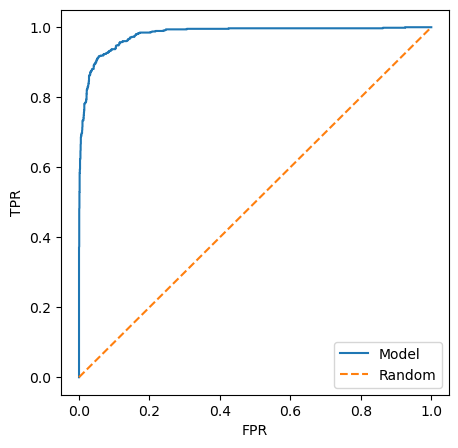

In [214]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [215]:
# predictions for negative class
neg = y_pred[y_val == 0]

# predictions for positive class
pos = y_pred[y_val == 1]

pos


array([6.56867665e-01, 9.61672325e-01, 5.32582884e-01, 8.60206249e-01,
       9.34277544e-01, 9.16902532e-01, 5.65034310e-01, 7.88608898e-01,
       1.23876477e-01, 5.27834644e-01, 9.74127037e-01, 9.94628797e-01,
       6.20541585e-01, 6.42102914e-01, 2.89893513e-01, 9.49981235e-01,
       1.33668264e-01, 9.99301751e-01, 8.41042398e-01, 9.99818114e-01,
       9.87540221e-01, 9.43130266e-01, 9.80919655e-01, 7.30816935e-01,
       8.53954869e-01, 7.45582795e-01, 9.44842234e-01, 5.37943856e-01,
       9.81029897e-01, 7.30816935e-01, 9.99936611e-01, 2.84670362e-01,
       9.98830287e-01, 9.99424946e-01, 3.01624042e-01, 9.49492905e-01,
       6.57340516e-01, 9.52497596e-01, 9.99931362e-01, 9.71247392e-01,
       6.00769186e-01, 9.98862893e-01, 8.60915055e-01, 9.40204571e-01,
       8.28052559e-01, 9.99928971e-01, 1.28553173e-01, 4.24828802e-01,
       9.82767179e-01, 9.99206322e-01, 7.95768868e-01, 8.53615574e-01,
       9.89854380e-01, 9.70193119e-01, 9.94005177e-01, 9.39267220e-01,
      

Alternative way of calculating ROC AUC score is calculating the probability of a randomly selected observation from a positive class having a higher score (model output probability) than the probability of a randomly selected observation from a negative class i.e., how well it separates positive examples from negative examples.

In [216]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.97956

### Precision and Recall

In [217]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
precision


array([0.27444398, 0.27455919, 0.27478992, ..., 1.        , 1.        ,
       1.        ])

In [218]:
def PR_curve_df(y_val, y_pred):
    scores = []

    # thresholds range 0 to 1 with 0.01 as step size
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val==1)
        actual_negative = (y_val==0)

        predicted_positive = (y_pred >= t)
        predicted_negative = (y_pred < t)

        tp = (predicted_positive & actual_positive).sum()
        tn = (predicted_negative & actual_negative).sum()

        fp = (predicted_positive & actual_negative).sum()
        fn = (predicted_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)

    return df_scores




In [219]:
df_pr_curve = PR_curve_df(y_val, y_pred)
df_pr_curve['diff'] = abs(df_pr_curve.precision - df_pr_curve.recall)

df_pr_curve.sort_values(by='diff')



,threshold,tp,fp,fn,tn,recall,precision,diff
49,0.49,581,72,73,1657,0.888379,0.889740,0.001360
48,0.48,584,76,70,1653,0.892966,0.884848,0.008118
47,0.47,585,78,69,1651,0.894495,0.882353,0.012142
50,0.50,576,69,78,1660,0.880734,0.893023,0.012289
46,0.46,586,79,68,1650,0.896024,0.881203,0.014821
...,...,...,...,...,...,...,...,...
97,0.97,252,1,402,1728,0.385321,0.996047,0.610726
98,0.98,234,0,420,1729,0.357798,1.000000,0.642202
99,0.99,192,0,462,1729,0.293578,1.000000,0.706422
0,0.00,654,1729,0,0,1.000000,0.274444,0.725556


At thresholds 0.48-0.49, precision and recall meet

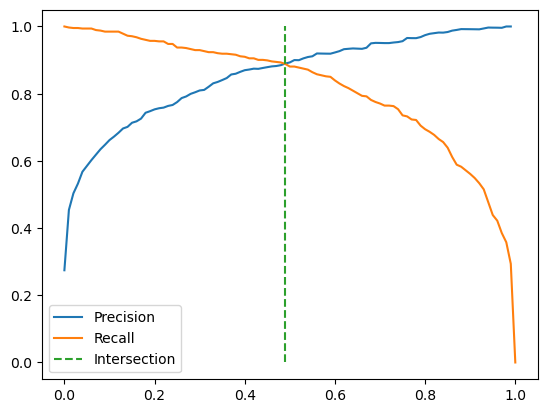

In [220]:
plt.plot(df_pr_curve.threshold, df_pr_curve['precision'], label='Precision')
plt.plot(df_pr_curve.threshold, df_pr_curve['recall'], label='Recall')
plt.plot([0.49, 0.49], [0, 1], label='Intersection', linestyle='--')
plt.legend()

### F1 Score

In [221]:
df_pr_curve['f1_score'] = (2*df_pr_curve['precision']*df_pr_curve['recall'])/(df_pr_curve['precision']+df_pr_curve['recall'])
df_pr_curve.sort_values(by='f1_score', ascending=False)

,threshold,tp,fp,fn,tn,recall,precision,diff,f1_score
51,0.51,576,64,78,1665,0.880734,0.900000,0.019266,0.890263
54,0.54,570,57,84,1672,0.871560,0.909091,0.037531,0.889930
53,0.53,572,60,82,1669,0.874618,0.905063,0.030446,0.889580
42,0.42,592,85,62,1644,0.905199,0.874446,0.030753,0.889557
40,0.40,595,89,59,1640,0.909786,0.869883,0.039903,0.889387
...,...,...,...,...,...,...,...,...,...
97,0.97,252,1,402,1728,0.385321,0.996047,0.610726,0.555678
98,0.98,234,0,420,1729,0.357798,1.000000,0.642202,0.527027
99,0.99,192,0,462,1729,0.293578,1.000000,0.706422,0.453901
0,0.00,654,1729,0,0,1.000000,0.274444,0.725556,0.430688


In [243]:
# creating train function
def train(df_train, y_train, C=1.0):
    
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    # Logistic regression with default regularization C=1.0
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [244]:
# creating predict function
def predict(df, dv, model):
    
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:,1]

    return y_pred

### K Fold Cross Validation

In [245]:
n_splits = 5

#initializing K Fold
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    del df_train['above_average']
    del df_val['above_average']
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [246]:
scores

[0.9784891235596622,
 0.9798043937194881,
 0.9830921309464058,
 0.9772656293569796,
 0.9776792651792652]

In [247]:
round(np.mean(scores),3), round(np.std(scores),3)

(0.979, 0.002)

Standard deviation across the folds is very less (0.002) and the average AUC score is 0.979

### Hyperparameter Tuning

In [253]:
# regulariztion strength for logistic regression. Higher C value = Low regulariztion strength.
C_choices = [0.01, 0.1, 0.5, 10]
results = {}
for C in tqdm(C_choices):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        del df_train['above_average']
        del df_val['above_average']
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
            
    results[C] = [round(np.mean(scores),3), round(np.std(scores),3)]

results

  0%|          | 0/4 [00:00<?, ?it/s]

{0.01: [0.952, 0.002],
 0.1: [0.972, 0.002],
 0.5: [0.978, 0.003],
 10: [0.984, 0.003]}